In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [129]:
import os
import urllib

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Visualisation
import matplotlib as mpl
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )

In [19]:
url = "https://raw.githubusercontent.com/priya-dwivedi/Udacity-ML-Nano-Degree/master/P0-Titanic-Survival/titanic_data.csv"
data_dir = "data/titanic/"
filename = "titanic_data.csv"

In [20]:
def downloadDataset(url, directory, filename):
    if not os.path.exists(directory):
        os.makedirs(directory)
    urllib.urlretrieve(url, directory + filename)

In [321]:
downloadDataset(url, data_dir, filename)

In [21]:
def plotCorrelationMap(df):
    corr = df.corr()
    cmap = sns.diverging_palette(220, 10, as_cmap = True)
    _, ax = plt.subplots(figsize = (12, 10))
    _ = sns.heatmap(
        data  = corr,
        cmap = cmap,
        annot = True,
        annot_kws = { 'fontsize' : 12 },
        ax = ax
    )

In [22]:
def plotDistribution(df, var, target, **kwargs):
    row = kwargs.get("row", None)
    col = kwargs.get("col", None)
    facet = sns.FacetGrid(df, hue = target, aspect = 3, row = row, col = col)
    facet.map(sns.kdeplot, var, shade = True)
    facet.set(xlim = (0, df[var].max()))
    facet.add_legend()

In [23]:
def plotCategories(df, cat, target, **kwargs):
    row = kwargs.get("row", None)
    col = kwargs.get("col", None)
    facet = sns.FacetGrid(df, aspect = 4, row = row, col = col)
    facet.map(sns.barplot, cat, target)
    facet.add_legend()

In [89]:
def plotModelVariableImportance(model, x, y):
#     x_features = [x for i, x in enumerate(x.columns)]
#     plt.figure(figsize = (8, 6))
#     plt.barh(range(len(model.feature_importances_)), model.feature_importances_, align = "center")
#     plt.yticks(range(len(model.feature_importances_)), x_features)
#     plt.xlabel("Importance")
#     plt.ylabel("Features")

    imp = pd.DataFrame(
        model.feature_importances_,
        columns = ["Importance"],
        index = x.columns
    )
    
    imp = imp.sort_values(
        ["Importance"], 
        ascending = True
    )
    imp.plot(
        kind = "barh",
        figsize=(20, 20)
    )
    print(model.score(x, y))

In [57]:
def plotVariableImportance(x, y):
    tree = DecisionTreeClassifier(random_state = 99)
    tree.fit(x, y)
    plotModelVariableImportance(tree, x, y)

In [92]:
train = pd.read_csv(data_dir + "train.csv")
test = pd.read_csv(data_dir + "test.csv")

In [93]:
titanic = train.append(test, ignore_index = True)

In [94]:
print("Dataset : {0}, Train : {1}, Test : {2}".format(titanic.shape, train.shape, test.shape))

Dataset : (1309, 12), Train : (891, 12), Test : (418, 11)


In [95]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [28]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [29]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


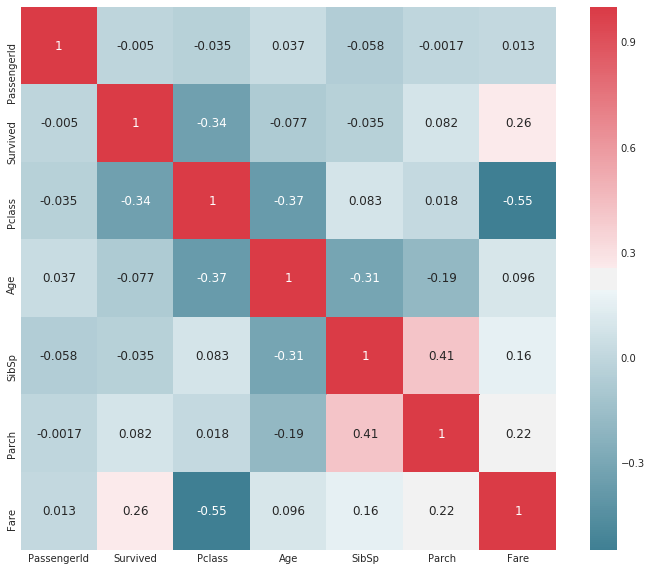

In [30]:
plotCorrelationMap(train)

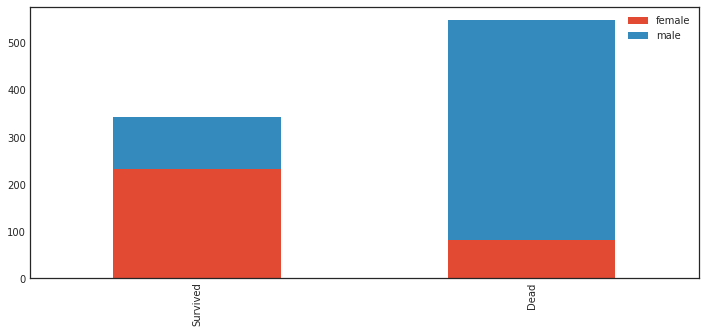

In [31]:
survived_sex = train[train['Survived']==1]['Sex'].value_counts()
dead_sex = train[train['Survived']==0]['Sex'].value_counts()
df = pd.DataFrame([survived_sex,dead_sex])
df.index = ['Survived','Dead']
df.plot(kind='bar',stacked=True, figsize=(12,5))
# train[train['Survived']==1]["Age"]

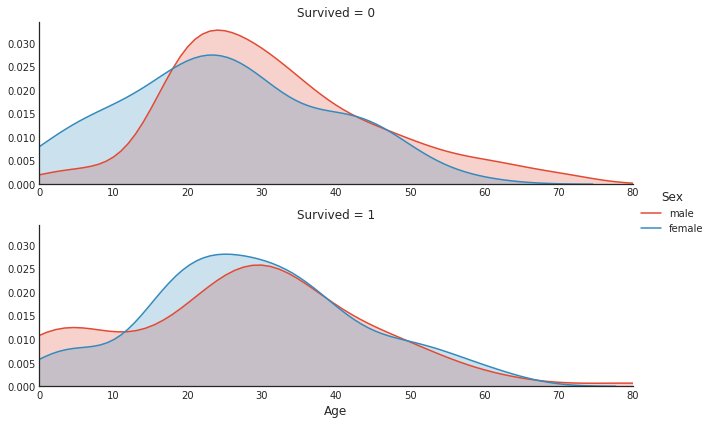

In [32]:
plotDistribution(train, var = "Age", target = "Sex", row = "Survived")

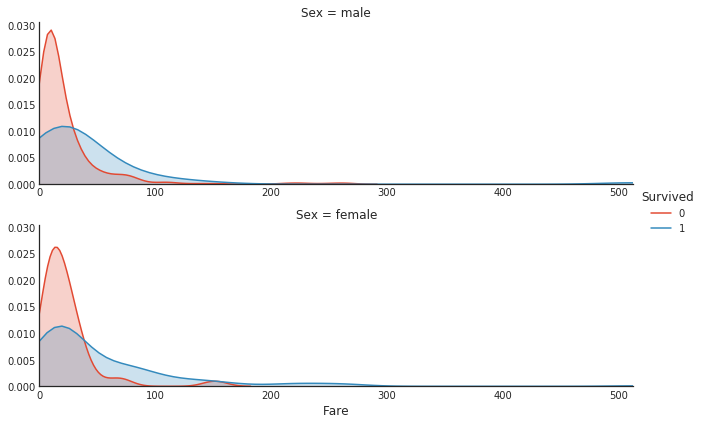

In [33]:
plotDistribution(train, var = "Fare", target = "Survived", row = "Sex")

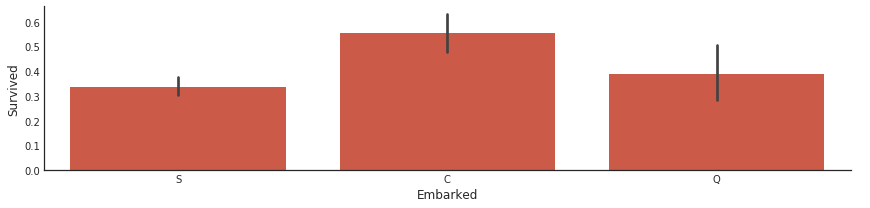

In [34]:
plotCategories(train, cat = "Embarked", target = "Survived")

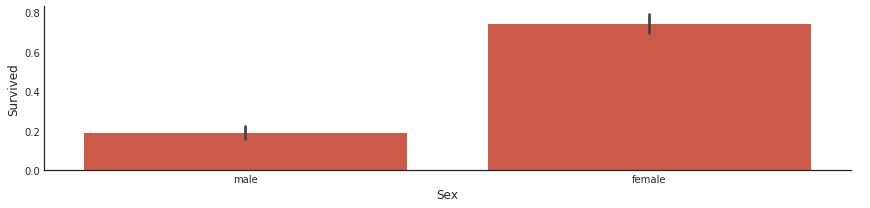

In [35]:
plotCategories(train, cat = "Sex", target = "Survived")

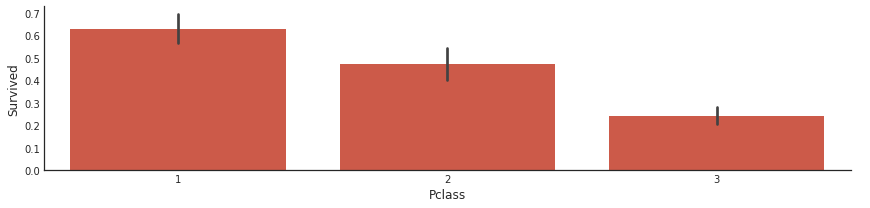

In [36]:
plotCategories(train, cat = "Pclass", target = "Survived")

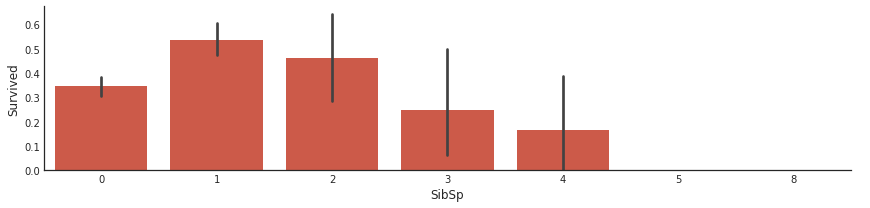

In [37]:
plotCategories(train, cat = "SibSp", target = "Survived")

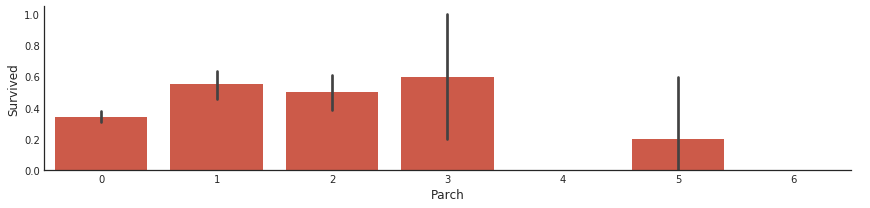

In [38]:
plotCategories(train, cat = "Parch", target = "Survived")

In [96]:
sex = pd.Series(np.where(titanic.Sex == "male", 1, 0), name = "Sex")
sex.head()

0    1
1    0
2    0
3    0
4    1
Name: Sex, dtype: int64

In [97]:
embarked = pd.get_dummies(titanic.Embarked, prefix = "Embarked")
embarked.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [98]:
pclass = pd.get_dummies(titanic.Pclass, prefix = "Pclass")
pclass.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


In [99]:
imputed = pd.DataFrame()
imputed["Age"] = titanic.Age.fillna(train.Age.mean())
imputed["Fare"] = titanic.Fare.fillna(train.Fare.mean())
imputed.head()

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


In [100]:
title = pd.DataFrame()
title["Title"] = titanic["Name"].map(lambda name : name.split(",")[1].split(".")[0].strip())

Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"

                    }

title["Title"] = title.Title.map(Title_Dictionary)
title = pd.get_dummies(title.Title)
title.head()

,Master,Miss,Mr,Mrs,Officer,Royalty
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0


In [101]:
cabin = pd.DataFrame()
cabin["Cabin"] = titanic["Cabin"].fillna("U")
cabin["Cabin"] = cabin["Cabin"].map(lambda c : c[0])
cabin = pd.get_dummies(cabin.Cabin, prefix = "Cabin")
cabin.head()

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1


In [102]:
family = pd.DataFrame()
family["FamilySize"] = titanic["Parch"] + train["SibSp"] + 1

family["FmailySingle"] = family["FamilySize"].map(lambda s : 1 if s == 1 else 0)
family["FmailySmall"] = family["FamilySize"].map(lambda s : 1 if 2 <= s < 5 else 0)
family["FmailyLarge"] = family["FamilySize"].map(lambda s : 1 if s >= 5 else 0)

family.head()

,FamilySize,FmailySingle,FmailySmall,FmailyLarge
0,2.0,0,1,0
1,2.0,0,1,0
2,1.0,1,0,0
3,2.0,0,1,0
4,1.0,1,0,0


In [105]:
# combined_x = pd.concat([imputed, embarked, cabin, sex], axis = 1)
combined_x = pd.concat([pclass, imputed, family, cabin, embarked, sex], axis = 1)
combined_x.head()

,Pclass_1,Pclass_2,Pclass_3,Age,Fare,FamilySize,FmailySingle,FmailySmall,FmailyLarge,Cabin_A,...,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Embarked_C,Embarked_Q,Embarked_S,Sex
0,0,0,1,22.0,7.2500,2.0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,1
1,1,0,0,38.0,71.2833,2.0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,1,26.0,7.9250,1.0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,1,0,0,35.0,53.1000,2.0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,1,35.0,8.0500,1.0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,1


In [115]:
# combined_train_x = combined_x
# combined_train_y = train.Survived


X = combined_x[:891]
Y = train.Survived

train_x , valid_x, train_y, valid_y = train_test_split(
    X,
    Y,
    train_size = .7
)

test_x = combined_x[891:]

print("Train Size : {0} - {1}, Valid Size : {2} - {3}, Test Size : {4}".format(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape, test_x.shape))

Train Size : (623, 22) - (623,), Valid Size : (268, 22) - (268,), Test Size : (418, 22)


0.99036918138


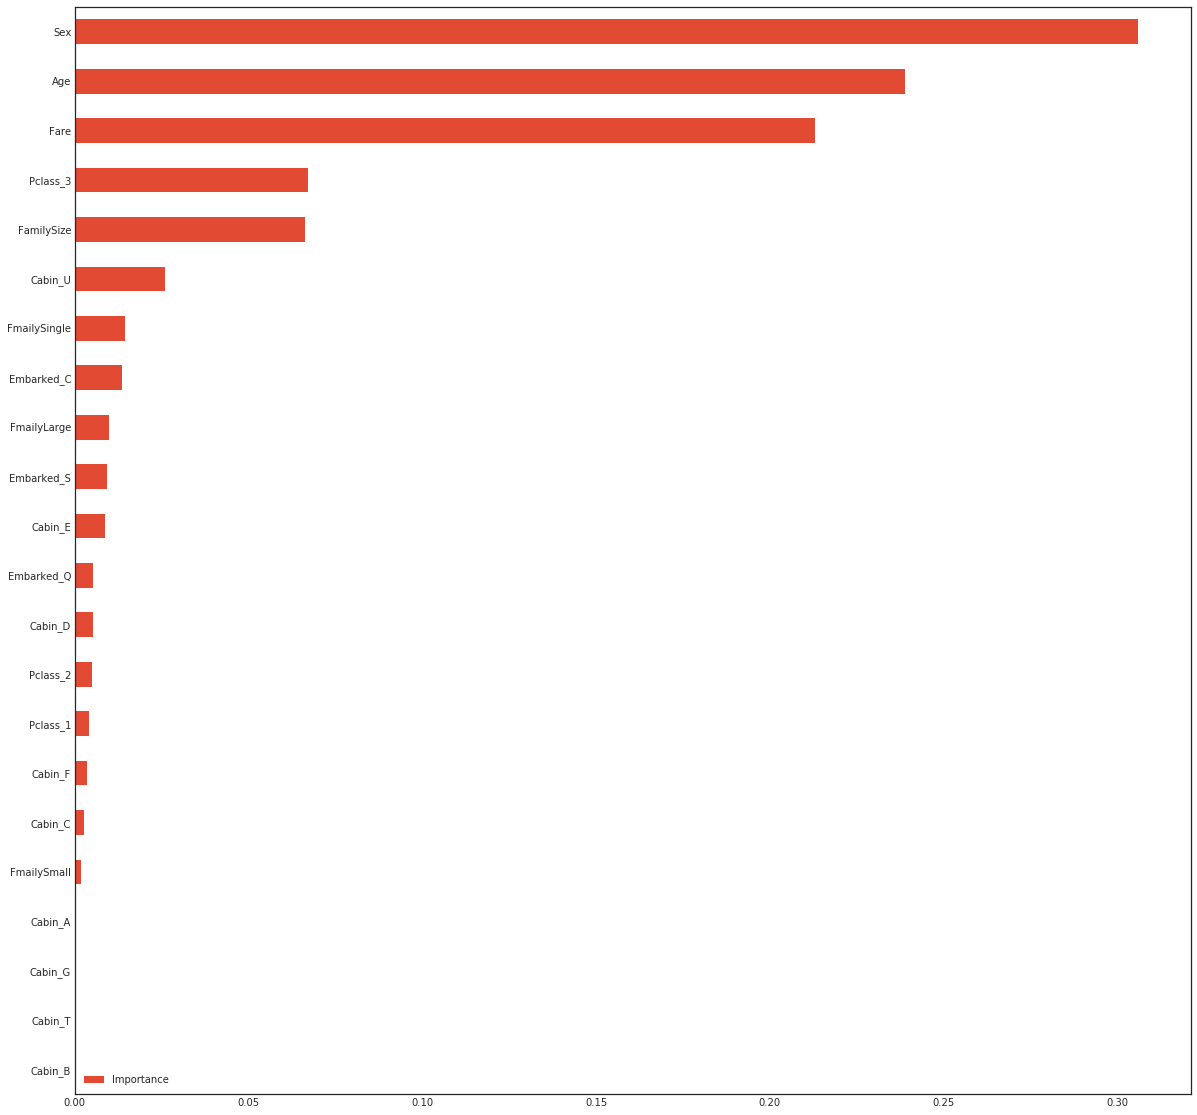

In [116]:
plotVariableImportance(train_x, train_y)

In [128]:
rf = RandomForestClassifier(max_depth = 3,n_estimators = 100, random_state = 0)
rf.fit(train_x, train_y)
print("Accuracy On Training Set : {0}".format(rf.score(train_x, train_y)))
print("Accuracy On Data Set : {0}".format(rf.score(valid_x, valid_y)))

Accuracy On Training Set : 0.83467094703
Accuracy On Data Set : 0.824626865672


In [132]:
scaler = StandardScaler()

train_scaled_x = scaler.fit_transform(train_x)
train_scaled_y = scaler.fit_transform(train_y)

valid_scaled_x = scaler.fit_transform(valid_x)
valid_scaled_y = scaler.fit_transform(valid_y)

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.  1.  1.  1.  1.  1.  0.  1.  0.  1.  0.  1.  1.  1.  0.  0.  0.  0.
  1.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.
  1.  1.  1.  0.  1.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  1.  1.
  0.  1.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  1.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.  1.  0.  1.  0.  1.  1.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.
  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.
  1.  0.  0.  0.  1.  0.  0.  1.  1.  0.  1.  1.  1.  1.  0.  1.  1.  0.
  1.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  1.  1.  1.  0.  0.  1.  0.  1.  1.  1.  0.  0.  1.  1.
  0.  1.  1.  0.  0.  0.  0.  1.  0.  1.  1.  1.  1.  0.  0.  0.  1.  1.
  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.
  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.
  1.  0.  0.  1.  1.  1.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.
  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.
  1.  0.  1.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.  1.  1.  0.  1.  1.
  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.
  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.  1.  0.  0.  0.  0.  0.  1.  1.
  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  1.
  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  1.  0.  1.  0.  0.  0.  1.
  1.  0.  1.  1.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  1.  1.  0.
  0.  0.  1.  0.  0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  1.  0.
  0.  1.  1.  0.  1.  0.  1.  1.  0.  0.  1.  1.  1.  0.  0.  0.  1.  1.
  1.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  1.  0.  1.  0.
  1.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.  0.
  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  1.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.  1.  0.  1.  0.  1.  0.
  1.  0.  0.  0.  0.  1.  1.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.  0.
  1.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  1.  0.  0.  0.  0.  0.
  1.  0.  0.  1.  0.  1.  1.  0.  0.  0.  1.  1.  1.  0.  1.  1.  0.  0.
  1.  1.  0.  0.  0.  1.  1.  0.  1.  0.  0.  1.  1.  0.  1.  0.  0.  1.
  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.